# PIK DIGITAL DAY (14.07.2018)
*by Alexander Drobotov* 

link: https://trainmydata.com/c/pik_digital_day_final_linear

In [2]:
import pandas as pd
import numpy as np

import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

### use patsy‘s formula language to produce design matrices
import patsy

# Green/Red colors: cm = sns.diverging_palette(10, 150, as_cmap=True)
cm = sns.light_palette("green", as_cmap=True)
sns.set_style("white")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import plotly
from plotly.graph_objs import Scatter, Layout

from os import listdir
import random

import os
os.chdir(r'C:\Users\drobotov\python\py_train_my_data\pik\data\new_data')

from IPython.display import Markdown, display

In [3]:
#load submission file
submission = pd.read_csv('sample submission.csv', index_col=0)

In [4]:
#print with markdown syntax
def printmd(string):
    display(Markdown(string))

In [5]:
#root mean square error for local validation
def rmse_loc(preds, actual):
    return np.sqrt(((preds - actual) ** 2).mean())

In [ ]:
#date to cnt
def month_flat(month):
    val = month.split()
    if(len(val)>1):
        val = val[0].split('-')
        return int(val[1]) - 1 + (int(val[0])-2015) * 12 + (int(val[2])-1) / (365/12)
    else:
        return -1

In [6]:
#calculate statistics by different categorical variables
def statistic_calc(data, metric, cat, alpha=70):
    global_mean = data[str(metric)].mean()
    
    func_list = [np.mean, np.max, np.min, np.median, np.std, np.sum, np.size]
    
    df = data.groupby(str(cat)).agg({str(metric): func_list}).reset_index()
    df.columns = [str(cat), str(metric)+'_'+str(cat)+'Mean', str(metric)+'_'+str(cat)+'Max', str(metric)+'_'+str(cat)+'Min', 
                  str(metric)+'_'+str(cat)+'Median', str(metric)+'_'+str(cat)+'Std', str(metric)+'_'+str(cat)+'Sum', 
                  str(metric)+'_'+str(cat)+'Size']
    df[str(metric)+'_'+str(cat)+'Sq'] = df[str(metric)+'_'+str(cat)+'Median'] ** 2
    df[str(metric)+'_'+str(cat)+'SML'] = (df[str(metric)+'_'+str(cat)+'Mean'] * df[str(metric)+'_'+str(cat)+'Size'] + 
                                          global_mean * alpha) / (df[str(metric)+'_'+str(cat)+'Size'] + alpha)
    data = pd.merge(data, df, on=str(cat), how='left')
    
    df = data.groupby(['bulk_id', str(cat)]).agg({str(metric): func_list}).reset_index()
    df.columns = ['bulk_id', str(cat), 'B'+str(metric)+'_'+str(cat)+'Mean', 'B'+str(metric)+'_'+str(cat)+'Max', 
                  'B'+str(metric)+'_'+str(cat)+'Min', 'B'+str(metric)+'_'+str(cat)+'Median', 'B'+str(metric)+'_'+str(cat)+'Std', 
                  'B'+str(metric)+'_'+str(cat)+'Sum', 'B'+str(metric)+'_'+str(cat)+'Size']
    df['B'+str(metric+'_'+str(cat))+'Sq'] = df['B'+str(metric)+'_'+str(cat)+'Median'] ** 2
    df['B'+str(metric+'_'+str(cat))+'SML'] = (df['B'+str(metric)+'_'+str(cat)+'Mean'] * df['B'+str(metric)+'_'+str(cat)+'Size']
                                              + global_mean * alpha) / (df['B'+str(metric)+'_'+str(cat)+'Size'] + alpha)
    data = pd.merge(data, df, on=['bulk_id', str(cat)], how='left')
    
    df = data.groupby(['id_gk', str(cat)]).agg({str(metric): func_list}).reset_index()
    df.columns = ['id_gk', str(cat), 'G'+str(metric)+'_'+str(cat)+'Mean', 'G'+str(metric)+'_'+str(cat)+'Max', 
                  'G'+str(metric)+'_'+str(cat)+'Min', 'G'+str(metric)+'_'+str(cat)+'Median', 'G'+str(metric)+'_'+str(cat)+'Std', 
                  'G'+str(metric)+'_'+str(cat)+'Sum', 'G'+str(metric)+'_'+str(cat)+'Size']
    df['G'+str(metric)+'_'+str(cat)+'Sq'] = df['G'+str(metric)+'_'+str(cat)+'Median'] ** 2
    df['G'+str(metric)+'_'+str(cat)+'SML'] = (df['G'+str(metric)+'_'+str(cat)+'Mean'] * df['G'+str(metric)+'_'+str(cat)+'Size']
                                              + global_mean * alpha) / (df['G'+str(metric)+'_'+str(cat)+'Size'] + alpha)
    data = pd.merge(data, df, on=['id_gk', str(cat)], how='left')    
    
    return data

In [7]:
#dictionary: from russian letters to latin
rus_to_trans_dict = {'Cтавка по ипотеке': 'st_ip', 'Автомойка': 'avtom',
       'Вентлияция':'ventil', 'Видеонаблюдение':'video', 'Вклады до 1 года':'vklad_do_1g',
       'Вклады от 1 года до 3 лет':'vklad_1_3g', 'Вклады свыше 3 лет':'vklad_bol_3l', 'Входные группы':'vh_gr',
       'Двор без машин':'dvor_bex_avto', 'Детский сад':'det_sad', 'До Кремля':'do_krem', 'До Садового(км)':'do_sadovogo',
       'До ТТК(км)':'do_ttk', 'До большой дороги на машине(км)':'do_dorogi', 'До метро пешком(км)':'do_metro',
       'До парка пешком(км)':'do_parka_peshkom', 'До парка(км)':'do_parka', 'До промки(км)':'do_promki',
       'До удобной авторазвязки на машине(км)':'do_avtorazv', 'Кладовые':'kladov', 'Класс объекта':'class',
       'Количество помещений':'kol_pomesch', 'Колясочные':'kolyas', 'Кондиционирование':'kondei', 'Курс':'kurs',
       'Лифт':'lift', 'Машиномест':'machinomest', 'Огорожена территория':'ogorozhen', 'Площадь двора':'plosch_dvor',
       'Площадь зеленой зоны в радиусе 500 м':'zelen_zona', 'Площадь земельного участка':'plosch_zemel_uchastok',
       'Площадь пром. зоны в радиусе 500 м':'plosch_prom_zona', 'Подземная парковка':'podzemn_park',
       'Поликлиника':'poliklin', 'Система мусоротведения':'sistema_musora', 'Спортивная площадка':'sport_graund',
       'Станций метро от кольца':'stancii_ot_kolca', 'ФОК':'fok', 'Школа':'school'}

In [9]:
%%time

#load train and test
train = pd.read_csv('train.csv', engine="python")
test = pd.read_csv('test.csv', engine="python")
train_and_test = pd.concat([train, test])

#load mortgage information data (http://www.cbr.ru/statistics/?PrtId=ipoteka)
real_morg_cred = pd.read_excel('real_morg_cred.xlsx')

train_and_test.rename(columns=rus_to_trans_dict, inplace=True)

#load flat
flat = pd.read_csv('flat.csv', encoding='cp1251')
flat.rename(columns={'id_bulk':'bulk_id'}, inplace=True)

#create shifted features
"""['vklad_do_1g', 'vklad_1_3g', 'vklad_bol_3l', 'st_ip']"""
df = pd.DataFrame()
for i in ['vklad_do_1g', 'vklad_1_3g', 'vklad_bol_3l', 'st_ip']:
    df[i + 'Diff'] = train_and_test.groupby('date1')[i].mean().diff().fillna(0)
    
    for j in [1,2,3]:
        df[i + str(j) + 'l'] = train_and_test.groupby('date1')[i].mean().shift(j).fillna(
            train_and_test.groupby('date1')[i].mean())
        df[i + 'Diff' + str(j) + 'l'] = df[i + 'Diff'].shift(j).fillna(df[i + 'Diff'])
    
for var in df.columns:
    df[var + 'Sq'] =  df[var] ** 2
    
df.reset_index(inplace=True)
    
train_and_test = pd.merge(train_and_test, df, on='date1', how='left')

#squares and logarithms for mortgage
for i in ['re_total_cred_mio_rur', 're_home_cred_qty', 're_home_cred_rur', 're_morg_qty', 're_morg_rur']:
    train_and_test[i + '_xSq'] = train_and_test[i + '_x'] ** 2
    train_and_test[i + '_ySq'] = train_and_test[i + '_y'] ** 2
    
    train_and_test[i + '_xLn'] = np.log1p(train_and_test[i + '_x'])
    train_and_test[i + '_yLn'] = np.log1p(train_and_test[i + '_y'])
    
    
"""GK: sum, size"""
squares_gk = flat.groupby(['bulk_id', 'id_gk']).agg({'square':[np.sum, np.size]}).reset_index()
squares_gk.columns = ['bulk_id', 'id_gk', 'BulkSqSum', 'BulkFlatSize']

train_and_test = pd.merge(train_and_test, squares_gk, on='bulk_id', how='left')


"""feature from flat.csv: floor, sections num"""
features_from_flat = flat.groupby('bulk_id').agg({'id_sec':[lambda x: len(x.unique())], 'floor':[np.max, np.min]}).reset_index()
features_from_flat.columns =  ['bulk_id', 'sec_num', 'floor_max', 'floor_min']

train_and_test = pd.merge(train_and_test, features_from_flat, on='bulk_id', how='left')


"""features with prices"""
price = pd.read_csv('price.csv', engine="python", encoding="utf8")
price = pd.merge(price, flat[['id_flatwork', 'bulk_id']], on='id_flatwork', how='left')

grouped_prices = price[price.pricem2>10000].groupby('bulk_id').agg({'pricem2': 
                                                              [np.mean, np.max, np.min, np.median, np.std]}).reset_index()
grouped_prices.columns = ['bulk_id', 'priceMean', 'priceMax', 'priceMin', 'priceMedian', 'priceStd']

train_and_test = pd.merge(train_and_test, grouped_prices, on='bulk_id', how='left')

mean_prices_by_gk = train_and_test.groupby('id_gk').agg({'price': 
                                                              [np.mean, np.max, np.min, np.median, np.std]}).reset_index()
mean_prices_by_gk.columns = ['id_gk', 'priceMean', 'priceMax', 'priceMin', 'priceMedian', 'priceStd']
mean_prices_by_gk = mean_prices_by_gk.add_prefix('gk_')
mean_prices_by_gk = mean_prices_by_gk.rename(columns={"gk_id_gk":"id_gk"})

train_and_test = pd.merge(train_and_test, mean_prices_by_gk, on='id_gk', how='left')


for i in ['priceMean', 'priceMax', 'priceMin', 'priceMedian', 'priceStd']:
    train_and_test[i] = train_and_test[i].fillna(train_and_test['gk_'+i])   


"""dates"""
train_and_test['date1'] = pd.to_datetime(train_and_test['date1'])

train_and_test['year'] = train_and_test['date1'].dt.year
train_and_test['month'] = train_and_test['date1'].dt.month

"""mean value per bulk_id"""

value_per_1_bulk = pd.DataFrame((train_and_test.groupby('month')['value'].sum().values / 
 train_and_test.groupby('month')['bulk_id'].agg({'bulk_id':[lambda x: len(x.unique())]}).values.T)).T
value_per_1_bulk.index = value_per_1_bulk.index + 1
value_per_1_bulk = value_per_1_bulk.reset_index().rename(columns={'index': 'month', 0:'MeanValPer1Bulk'})

train_and_test = pd.merge(train_and_test, value_per_1_bulk, on='month', how='left')


"""prices"""
train_and_test['flatPrice'] = train_and_test['price'] * train_and_test['mean_sq']
train_and_test['flatPriceSq'] = train_and_test['flatPrice'] ** 2
train_and_test['flatPriceLn'] = np.log1p(train_and_test['flatPrice'])

train_and_test['priceSq'] = train_and_test['price'] ** 2
train_and_test['priceLn'] = np.log1p(train_and_test['price'])
train_and_test['mean_sqSQ'] = train_and_test['mean_sq'] ** 2
train_and_test['mean_flSq'] = train_and_test['mean_fl'] ** 2


"""start sales month"""
start_sales = train_and_test.groupby(['bulk_id', 'spalen'])['date1'].min().reset_index()
start_sales['start_sales'] = 1
train_and_test = pd.merge(train_and_test, start_sales, on=['bulk_id', 'spalen', 'date1'], how='left')
train_and_test['start_sales'] = train_and_test['start_sales'].fillna(0)


train_and_test = pd.merge(train_and_test, real_morg_cred[real_morg_cred.city == 'moskva'].groupby(
    ['year', 'month']).sum().reset_index(), on=['year', 'month'], how='left') 
train_and_test = pd.merge(train_and_test, real_morg_cred[real_morg_cred.city == 'mos_obl'].groupby(
    ['year', 'month']).sum().reset_index(), on=['year', 'month'], how='left') 

Wall time: 7.97 s


In [131]:
%%time
#calculate statistics by groups
for i in ['price', 'mean_sq', 'mean_fl', 'flatPrice']:   #??? start square?
    for j in ['spalen', 'month', 'class']:   #??? year?
        
        train_and_test = statistic_calc(data=train_and_test, metric=i, cat=j)

Wall time: 19.3 s


In [125]:
#convert dates to integers
flat['d_settle'] = flat['date_settle'].apply(str).apply(month_flat)
flat['d_sales'] = flat['date_salestart'].apply(month_flat)
flat['d_start'] = flat['flat_startsale'].apply(str).apply(month_flat)

flat_f = flat.groupby(['bulk_id', 'spalen', 'd_settle', 'd_sales', 'd_start'])['square'].sum().reset_index()

In [308]:
%%time
#calculate sum of shifted squares by startsales date & id keys

stat_1 = {}
stat_2 = {}
stat_3 = {}

for i in range(len(train_and_test)):
    row = train_and_test[['bulk_id', 'spalen', 'month_cnt']].iloc[i,:]
    
    stat_1[i] = flat_f[(flat_f['bulk_id'] == row[0]) & (flat_f['spalen'] == row[1]) & 
                       (flat_f['d_sales'] <= row[2]) & (flat_f['d_start'] <= row[2])]['square'].sum()
    
    stat_2[i] = flat_f[(flat_f['bulk_id'] == row[0]) & (flat_f['spalen'] == row[1]) & 
                       (flat_f['d_sales'] <= row[2]) & (flat_f['d_start'] <= row[2]) &
                      (flat_f['d_start'] >= row[2]-1)]['square'].sum()
    
    stat_3[i] = flat_f[(flat_f['bulk_id'] == row[0]) & (flat_f['spalen'] == row[1]) & 
                       (flat_f['d_sales'] <= row[2]) & (flat_f['d_start'] <= row[2]) &
                      (flat_f['d_start'] >= row[2]-2)]['square'].sum()
    
train_and_test['stat_1'] = pd.Series(stat_1)
train_and_test['stat_2'] = pd.Series(stat_2)
train_and_test['stat_3'] = pd.Series(stat_3)    

Wall time: 2min 7s


In [315]:
"""
section: 'id_section', 'section'
GK: 'id_gk', 'Количество помещений', 'Площадь земельного участка', 'Машиномест', До Кремля', 'До ТТК(км)', 'До Садового(км)'

"""

categorical_col = ['spalen', 'bulk_id', 'id_gk', 'month',
                   'class', 'kondei', 'ventil', 'video'] #categorical

binary_col = ['ogorozhen', 'fok', 'vh_gr', 'avtom', 'kladov', 'kolyas', 
              'podzemn_park', 'dvor_bex_avto'] #binary


to_drop_cols = ['date1', 'plan_l', 'plan_m','plan_s', 'value','vid_0', 'vid_1', 'vid_2', 'id', 
                'start_square', 'sport_graund', 'lift', 'sistema_musora']

other_cols = set(train_and_test.columns) - set(categorical_col + binary_col + to_drop_cols)

In [316]:
train = pd.DataFrame()
for i in binary_col:
    if i == 'fok':
        train['fok'] = train_and_test[i].copy()
    else:
        train[i] = train_and_test[i].replace({'да': 1, 'нет': 0})

In [317]:
for i in other_cols:
    train[i] = train_and_test[i].copy()

In [318]:
lbl = LabelEncoder()
label_dict = {}
for lab in categorical_col:
    label = lbl.fit_transform(train_and_test[lab].unique())
    label_dict[lab] = dict(zip(lbl.classes_, range(len(lbl.classes_))))

In [319]:
for cat in categorical_col:
    train[cat] = train_and_test[cat].map(label_dict[cat])

In [320]:
"""One-Hot Encoding"""
train = pd.concat([train, pd.get_dummies(train.spalen, prefix='s')], axis=1)
train = pd.concat([train, pd.get_dummies(train.bulk_id, prefix='b')], axis=1)
train = pd.concat([train, pd.get_dummies(train.month, prefix='m')], axis=1)
train = pd.concat([train, pd.get_dummies(train.id_gk, prefix='g')], axis=1)
train = pd.concat([train, pd.get_dummies(train['class'], prefix='c')], axis=1)
train = pd.concat([train, pd.get_dummies(train['kondei'], prefix='co')], axis=1)
train = pd.concat([train, pd.get_dummies(train['ventil'], prefix='ve')], axis=1)
train = pd.concat([train, pd.get_dummies(train['video'], prefix='vi')], axis=1)

In [321]:
test_index = train_and_test[train_and_test.value.isnull()].index
test = train.loc[test_index, :].copy()
train = train.loc[set(train.index) - set(test_index), :]
y = train_and_test.loc[set(train.index) - set(test_index),'value']
print(train.shape, test.shape)
train['value'] = y

(9244, 824) (1817, 824)


In [333]:
%%time
### enter an equation

eq = 'value ~  m_1 + m_2 + m_4 + m_8 + m_9 + m_10 + m_11 + np.log1p(month_cnt) \
+ b_1 + b_8 + b_27 + b_33 + b_39 + b_60 + b_73 + b_85 + b_64 + b_65 + b_81 + b_98 + b_100 + b_150 + b_99 + \
+ b_107 + b_110 + b_120 + b_130 + b_147 + b_151 + b_172 + b_181 + b_184 \
+ b_209 + b_220 + b_198  + b_200 + + b_225 + b_233 + b_249 \
+ g_6 + g_12 + g_29 + g_11 \
+ co_1 + ve_0 + vi_0 + vi_2 \
+ Bmean_sq_monthMin + Gmean_sq_spalenStd + Bmean_fl_spalenMedian + Bmean_sq_monthMax + Bprice_spalenMax + Bmean_fl_spalenSize \
+ BulkFlatSize\
+ st_ipDiff1l + re_morg_qty_xSq + re_total_cred_mio_rur_x + re_morg_rur_y + vklad_do_1gDiff1l \
+ price_spalenMin + price_spalenStd \
+ np.log1p(priceSq) + priceMin + np.log1p(mean_sqSQ) + spalen + s_1 + s_2 + s_0 + s_4 \
+ np.power(st_ip2l, 2) \
+ np.power(floor_min, 2) + mean_fl + mean_flSq\
+ BulkSqSum + gk_priceStd \
+ stat_1 + stat_2 + np.log1p(stat_3) + np.subtract(stat_3, stat_1) \
+ start_sales \
+ det_sad + plosch_dvor + vh_gr - 1'

y, X = patsy.dmatrices(eq, train, return_type='dataframe')

### column's names

X_names = list(X.columns[:])

### model fit

mdl = smf.OLS(y, X).fit()

### create DF with model's results

mdl_param = mdl.params
data_mdl = X * mdl.params

### model & residuals
model = data_mdl.sum(axis=1)
residuals = residuals = (np.array(y).T - np.array(model)).T
residuals = list(residuals.reshape(len(y)))

print(round(mdl.pvalues, 2).sort_values(ascending=False)[:5])

print("RMSE = {}".format(rmse_loc(model.clip(0,3000).values, train['value'])))
print("RMSE adj = {}".format(rmse_loc(np.round((model.clip(0,3000).values / train.mean_sq), 0) * train.mean_sq, train['value'])))
print(mdl.summary())

train['model'] = model.values

Bmean_fl_spalenMedian    0.48
m_11                     0.38
Bmean_fl_spalenSize      0.19
b_1                      0.15
m_2                      0.14
dtype: float64
RMSE = 255.90778330311684
RMSE adj = 256.5669436307416
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     112.6
Date:                Tue, 17 Jul 2018   Prob (F-statistic):               0.00
Time:                        17:21:53   Log-Likelihood:                -64481.
No. Observations:                9244   AIC:                         1.291e+05
Df Residuals:                    9164   BIC:                         1.297e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                

In [334]:
len(X_names)

83

In [335]:
np.seterr(divide='ignore', invalid='ignore')
corr_dic = {}

for i in train.columns:
    if train[i].dtype == 'datetime64[ns]' or i == 'Intercept':
        corr_dic[i] = 0
    else:
        corr_dic[i] = np.corrcoef(np.array(residuals), np.array(train[i]))[1][0]
    
pd.Series(corr_dic).dropna().sort_values()[:-1].reset_index().style.background_gradient(cmap=cm)
#.style.bar(color='#5fba7d')

In [336]:
np.seterr(divide='ignore', invalid='ignore')
corr_dic = {}

for i in train.columns:
    if train[i].dtype == 'datetime64[ns]' or i == 'Intercept':
        corr_dic[i] = 0
    else:
        corr_dic[i] = np.corrcoef(y.values.T, np.array(train[i]))[1][0]
    
pd.Series(corr_dic).dropna().sort_values()[:-1].reset_index().style.background_gradient(cmap=cm)
#.style.bar(color='#5fba7d')

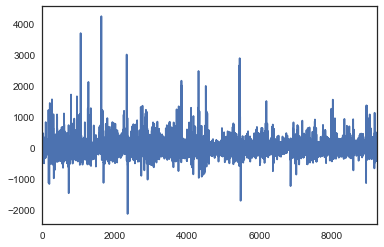

In [337]:
#residuals
pd.Series(residuals).plot();

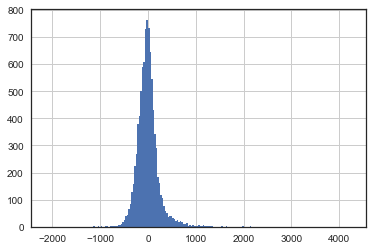

In [338]:
#residuals histogram
pd.Series(residuals).hist(bins=200);

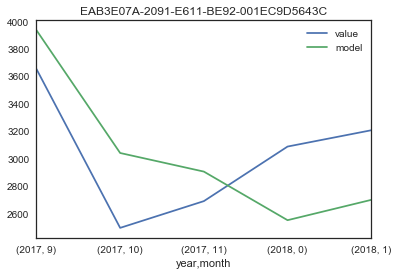

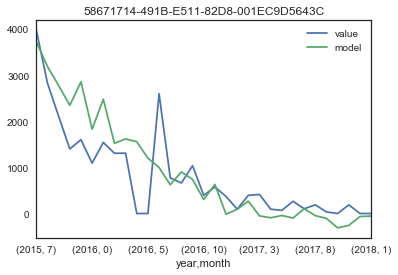

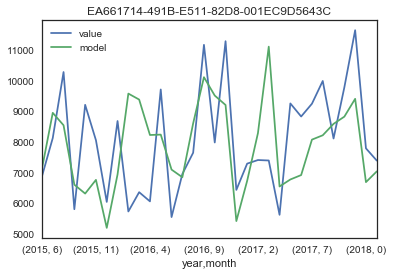

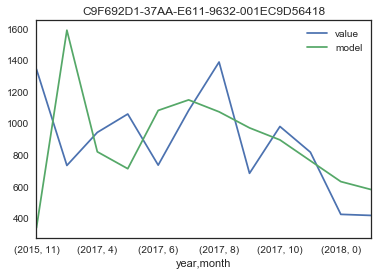

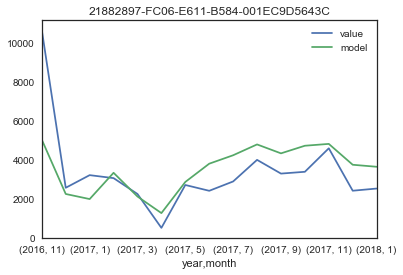

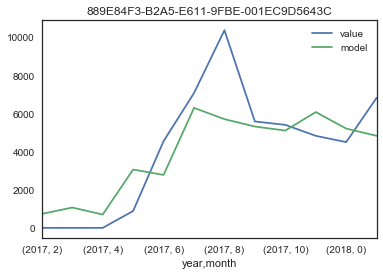

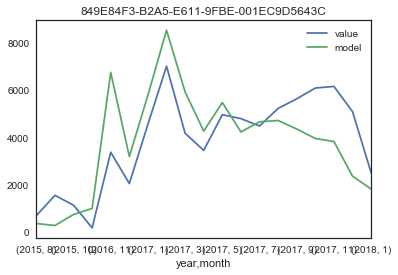

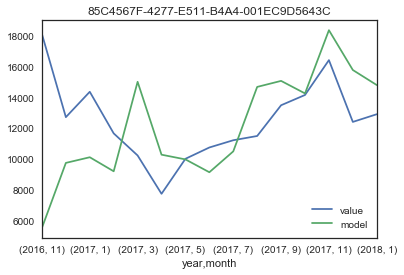

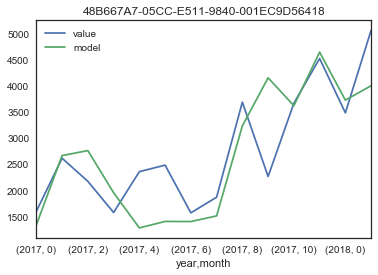

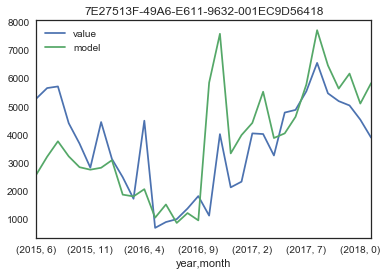

In [339]:
#model vs actual by ID_GK
key = 'id_gk'

for i in train[key].unique()[:10]:
    df = train[train[key] == int(i)][['year', 'month', 'value', 'model']]
    df = df.groupby(['year', 'month']).sum()
    
    df.plot(title=list(label_dict[key].keys())[i])

In [340]:
#add factors' names from the model

regression_factors = []
for i in train.columns:
    for j in X_names:
        if i in j:
            regression_factors.append(i)
            
regression_factors = regression_factors + ['value']

## CROSS-VALIDATION

In [341]:
%%time
"""cross-validation datasets"""

K=10

train.reset_index(drop=True, inplace=True)
kf = KFold(n_splits=K, random_state=17, shuffle=True)

for i, (train_index, valid_index) in enumerate(kf.split(range(len(train)))):
    train_set = train.loc[train_index, regression_factors]
    valid_set = train.loc[valid_index, regression_factors]

    train_set.to_csv(r'C:\Users\drobotov\python\py_train_my_data\pik\output\folds\train_' + str(i) + '.csv', index=False)
    valid_set.to_csv(r'C:\Users\drobotov\python\py_train_my_data\pik\output\folds\valid_' + str(i) + '.csv',index=False)

Wall time: 11.1 s


In [342]:
%%time

rmse_score_train = {}
rmse_score_val = {}
rmse_score_train_asis = {}
rmse_score_val_asis = {}

for i in range(kf.n_splits):
    
    train_set = pd.read_csv(r'C:\Users\drobotov\python\py_train_my_data\pik\output\folds\train_' + str(i) + '.csv', 
                            encoding="cp1251")
    val_set = pd.read_csv(r'C:\Users\drobotov\python\py_train_my_data\pik\output\folds\valid_' + str(i) + '.csv', 
                          encoding="cp1251")
    

    y, X = patsy.dmatrices(eq, train_set, return_type='dataframe')
    y_val, X_val = patsy.dmatrices(eq, val_set, return_type='dataframe')
    
    mdl = smf.OLS(y, X).fit()
    
    pred_train = (X * mdl.params).sum(axis=1)
    pred_val = (X_val[X.columns] * mdl.params).sum(axis=1)
    
    pred_train_asis = (X[X.columns] * mdl_param).sum(axis=1)
    pred_val_asis = (X_val[X.columns] * mdl_param).sum(axis=1)
    
    
    rmse_score_train[str(i)] = rmse_loc(pred_train, train_set['value'])
    rmse_score_val[str(i)] = rmse_loc(pred_val, val_set['value'])
    
    rmse_score_train_asis[str(i)] = rmse_loc(pred_train_asis, train_set['value'])
    rmse_score_val_asis[str(i)] = rmse_loc(pred_val_asis, val_set['value'])
    

Wall time: 4.9 s


In [343]:
printmd("when you train random datasets, you get **{}** RMSE for train data set \
and **{}** RMSE for validation".format(
    round(pd.Series(rmse_score_train).mean(),4), round(pd.Series(rmse_score_val).mean(),4)))

printmd("when you have coef from the current model, you get **{}** RMSE for train data set \
and **{}** RMSE for validation".format(
    round(pd.Series(rmse_score_train_asis).mean(), 4), round(pd.Series(rmse_score_val_asis).mean(), 4)))

when you train random datasets, you get **258.6882** RMSE for train data set and **261.888** RMSE for validation

when you have coef from the current model, you get **258.9087** RMSE for train data set and **257.8162** RMSE for validation

## FINAL RESULT

In [344]:
#to sub
test['value'] = 0
y_tes, X_tes = patsy.dmatrices(eq, test, return_type='dataframe')
test['value'] = (X_tes * mdl_param).sum(axis=1).clip(0,3000).values

submission['value'] = (X_tes * mdl_param).sum(axis=1).clip(0,3000).values
#submission.to_csv('sub00.csv')

In [345]:
submission.value.sum()

328885.0976074582